# HM2: Numerical Optimization for Logistic Regression.

### Name: Michael Eng


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/HM2/HM2.html


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.01426002 -0.0214525   0.0142114  -0.01920219 -0.03301505 -0.02590305
   0.10470225  0.11214563]]
test std = 
[[0.94688349 0.96788453 0.96314811 0.99725731 0.94316074 0.86209049
  1.1834352  1.09614732]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [5]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [6]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [8]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [9]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.585037238763272
Objective value at t=2 is 0.5418677512636944
Objective value at t=3 is 0.5188175653602003
Objective value at t=4 is 0.5044361886968358
Objective value at t=5 is 0.4946618562860769
Objective value at t=6 is 0.4876623461162789
Objective value at t=7 is 0.4824717335614427
Objective value at t=8 is 0.47852461776919225
Objective value at t=9 is 0.4754651701813792
Objective value at t=10 is 0.47305752800114365
Objective value at t=11 is 0.4711391959768166
Objective value at t=12 is 0.46959483062078683
Objective value at t=13 is 0.4683405719381968
Objective value at t=14 is 0.46731422884952234
Objective value at t=15 is 0.46646889889866394
Objective value at t=16 is 0.46576869404753163
Objective value at t=17 is 0.4651858050206751
Objective value at t=18 is 0.46469844173768643
Objective value at t=19 is 0.4642893614705294
Objective value at t=20 is 0.4639447997170621
Objective value at t=21 is 0.463653682

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [10]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    d = xi.shape[0]
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [11]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [12]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5297505540310775
Objective value at epoch t=1 is 0.5067633268048698
Objective value at epoch t=2 is 0.5013113534657341
Objective value at epoch t=3 is 0.5014539343699199
Objective value at epoch t=4 is 0.4930303287455546
Objective value at epoch t=5 is 0.49275783630729003
Objective value at epoch t=6 is 0.4820457703080809
Objective value at epoch t=7 is 0.49186810067311315
Objective value at epoch t=8 is 0.48016620043864205
Objective value at epoch t=9 is 0.4790141454607807
Objective value at epoch t=10 is 0.47902081592160856
Objective value at epoch t=11 is 0.48082132040090836
Objective value at epoch t=12 is 0.4757383944592851
Objective value at epoch t=13 is 0.47795193792634566
Objective value at epoch t=14 is 0.47639197004544487
Objective value at epoch t=15 is 0.472696169174473
Objective value at epoch t=16 is 0.47341266982661906
Objective value at epoch t=17 is 0.471284799063484
Objective value at epoch t=18 is 0.4703926415707874
Objective value 

# 4. Compare GD with SGD

Plot objective function values against epochs.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if sys.path[0] == '':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: MatplotlibDepre

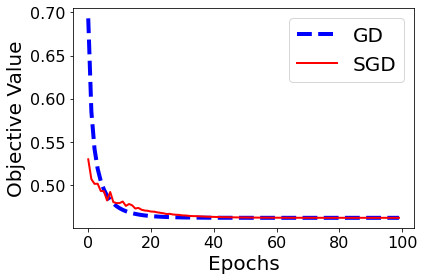

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [14]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [15]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.215625


In [16]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.25


# 6. Mini-batch SGD (fill the code)



## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [17]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    
    d = xi.shape[0]
    
    yx = numpy.multiply(yi, xi) # b-by-d matrix
    yxw = numpy.dot(yx, w) # b-by-1 matrix
    
    # calculate objective function Q_i
    loss = 1 / b * numpy.sum(numpy.log(1 + numpy.exp(-yxw))) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar

    obj = loss + reg 

    # calculate stochastic gradient
    g_loss = numpy.sum(-yx.T / (1 + numpy.exp(yxw)).T, axis=1) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [18]:

# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
        
    for t in range(max_epoch):
        indecies = numpy.arange(n)
        numpy.random.shuffle(indecies)
        objval = 0 # accumulate the objective values

        batches = int(n / b)
        for j in range(batches):
            first_index = j * b
            last_index = (j + 1) * b
            xb = x[indecies[first_index:last_index],:]
            yb = y[indecies[first_index:last_index],:]
            
            obj, g = mb_stochastic_objective_gradient(w, xb, yb, lam, b)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= batches 
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

## 6.3. Run MB-SGD

In [32]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter

stepsizes = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.8, 1.0, 10.0, 100.0, 1000.0]
errors_train8 = []
errors_test8 = []
objvals_mbsgd8 = []

for stepsize in stepsizes:
    w_tmp, objval_tmp = mb_sgd(x_train, y_train, lam, b, stepsize)
    f_train = predict(w_tmp, x_train)
    diff = numpy.abs(f_train - y_train) / 2
    error_train = numpy.mean(diff)
    f_test = predict(w_tmp, x_test)
    diff = numpy.abs(f_test - y_test) / 2
    error_test = numpy.mean(diff)
    
    errors_train8.append(error_train)
    errors_test8.append(error_test)
    objvals_mbsgd8.append(objval_tmp)
    


Objective value at epoch t=0 is 0.6927291065498146
Objective value at epoch t=1 is 0.691902123794435
Objective value at epoch t=2 is 0.6911636242931234
Objective value at epoch t=3 is 0.6905025596920015
Objective value at epoch t=4 is 0.6899074995189093
Objective value at epoch t=5 is 0.6893755949328375
Objective value at epoch t=6 is 0.6888985920676732
Objective value at epoch t=7 is 0.6884687075016158
Objective value at epoch t=8 is 0.6880846589348328
Objective value at epoch t=9 is 0.6877390142242263
Objective value at epoch t=10 is 0.6874285641064091
Objective value at epoch t=11 is 0.6871501630843515
Objective value at epoch t=12 is 0.6868997638899217
Objective value at epoch t=13 is 0.6866746141543303
Objective value at epoch t=14 is 0.6864726597544581
Objective value at epoch t=15 is 0.6862903559249173
Objective value at epoch t=16 is 0.6861271388452047
Objective value at epoch t=17 is 0.6859802934351665
Objective value at epoch t=18 is 0.6858479944037965
Objective value at epoc

Objective value at epoch t=69 is 0.6254279674594087
Objective value at epoch t=70 is 0.625424519561179
Objective value at epoch t=71 is 0.6254214149695223
Objective value at epoch t=72 is 0.6254186228343126
Objective value at epoch t=73 is 0.6254161165938553
Objective value at epoch t=74 is 0.6254138492321454
Objective value at epoch t=75 is 0.6254118169345254
Objective value at epoch t=76 is 0.6254099849325387
Objective value at epoch t=77 is 0.6254083391486878
Objective value at epoch t=78 is 0.625406855065433
Objective value at epoch t=79 is 0.6254055204234417
Objective value at epoch t=80 is 0.6254043181892283
Objective value at epoch t=81 is 0.6254032371600087
Objective value at epoch t=82 is 0.6254022643958017
Objective value at epoch t=83 is 0.6254013891227286
Objective value at epoch t=84 is 0.625400599671039
Objective value at epoch t=85 is 0.6253998900150248
Objective value at epoch t=86 is 0.6253992507733582
Objective value at epoch t=87 is 0.6253986769550426
Objective value

Objective value at epoch t=58 is 0.46195223808278146
Objective value at epoch t=59 is 0.46194991086913717
Objective value at epoch t=60 is 0.4619476005496622
Objective value at epoch t=61 is 0.46194660707251545
Objective value at epoch t=62 is 0.46194412689009906
Objective value at epoch t=63 is 0.46194496915756034
Objective value at epoch t=64 is 0.46194379465936447
Objective value at epoch t=65 is 0.46194199350227183
Objective value at epoch t=66 is 0.4619419551450494
Objective value at epoch t=67 is 0.4619413547513931
Objective value at epoch t=68 is 0.46193951740354267
Objective value at epoch t=69 is 0.46193936162194815
Objective value at epoch t=70 is 0.4619387736395611
Objective value at epoch t=71 is 0.4619384851831955
Objective value at epoch t=72 is 0.4619382502674069
Objective value at epoch t=73 is 0.4619373704002414
Objective value at epoch t=74 is 0.4619371841470139
Objective value at epoch t=75 is 0.4619371107776894
Objective value at epoch t=76 is 0.46193691642425183
Ob

Objective value at epoch t=31 is 0.4808547660610155
Objective value at epoch t=32 is 0.478728109276103
Objective value at epoch t=33 is 0.4735811562232016
Objective value at epoch t=34 is 0.4762364295285799
Objective value at epoch t=35 is 0.4759987756291967
Objective value at epoch t=36 is 0.47237490962702794
Objective value at epoch t=37 is 0.4712867630649856
Objective value at epoch t=38 is 0.47076471177905044
Objective value at epoch t=39 is 0.4700667644478484
Objective value at epoch t=40 is 0.4686063266806391
Objective value at epoch t=41 is 0.46836222553521667
Objective value at epoch t=42 is 0.4684417786259735
Objective value at epoch t=43 is 0.4666478713386142
Objective value at epoch t=44 is 0.4668791926569841
Objective value at epoch t=45 is 0.46652946315634375
Objective value at epoch t=46 is 0.4662689074657952
Objective value at epoch t=47 is 0.4659663467811006
Objective value at epoch t=48 is 0.46535622901198337
Objective value at epoch t=49 is 0.46469739182115327
Objecti

Objective value at epoch t=25 is 1.3506321928991936
Objective value at epoch t=26 is 1.1347379425820532
Objective value at epoch t=27 is 1.2325834746328284
Objective value at epoch t=28 is 1.0997716897767749
Objective value at epoch t=29 is 0.958234495700552
Objective value at epoch t=30 is 0.7986529426331515
Objective value at epoch t=31 is 0.8225004073780957
Objective value at epoch t=32 is 0.8130519252827423
Objective value at epoch t=33 is 0.6829331979218243
Objective value at epoch t=34 is 0.6699719183075947
Objective value at epoch t=35 is 0.6431101004916793
Objective value at epoch t=36 is 0.6164341573281431
Objective value at epoch t=37 is 0.5874465553833447
Objective value at epoch t=38 is 0.5794229018230574
Objective value at epoch t=39 is 0.5670555010874205
Objective value at epoch t=40 is 0.5545215055966113
Objective value at epoch t=41 is 0.5282996365091202
Objective value at epoch t=42 is 0.5157213291589489
Objective value at epoch t=43 is 0.5241973147613745
Objective val

/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp



Objective value at epoch t=2 is inf
Objective value at epoch t=3 is inf
Objective value at epoch t=4 is inf
Objective value at epoch t=5 is inf
Objective value at epoch t=6 is inf
Objective value at epoch t=7 is inf
Objective value at epoch t=8 is inf
Objective value at epoch t=9 is inf
Objective value at epoch t=10 is inf
Objective value at epoch t=11 is inf
Objective value at epoch t=12 is inf
Objective value at epoch t=13 is inf
Objective value at epoch t=14 is inf
Objective value at epoch t=15 is 39.52396335032003
Objective value at epoch t=16 is 35.29643986455116
Objective value at epoch t=17 is 33.76841922014711
Objective value at epoch t=18 is 24.274585707910507
Objective value at epoch t=19 is 26.95977092501834
Objective value at epoch t=20 is 21.452450476913242
Objective value at epoch t=21 is inf
Objective value at epoch t=22 is inf
Objective value at epoch t=23 is 15.289910878118414
Objective value at epoch t=24 is 13.949182051284206
Objective value at epoch t=25 is 14.3441

Objective value at epoch t=80 is 0.5999375116853563
Objective value at epoch t=81 is 0.5918195622101614
Objective value at epoch t=82 is 0.5597877595888155
Objective value at epoch t=83 is 0.5738581671588664
Objective value at epoch t=84 is 0.5633751270911094
Objective value at epoch t=85 is 0.5503712566062382
Objective value at epoch t=86 is 0.5291353754095027
Objective value at epoch t=87 is 0.518688958923138
Objective value at epoch t=88 is 0.5152946406332675
Objective value at epoch t=89 is 0.5071528936772147
Objective value at epoch t=90 is 0.502632111678582
Objective value at epoch t=91 is 0.49993980455040987
Objective value at epoch t=92 is 0.5038647866364092
Objective value at epoch t=93 is 0.4892921506716451
Objective value at epoch t=94 is 0.48095687820995786
Objective value at epoch t=95 is 0.4914633738314203
Objective value at epoch t=96 is 0.48499973369953997
Objective value at epoch t=97 is 0.48617540549135113
Objective value at epoch t=98 is 0.4827716286043118
Objective 

In [33]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change

errors_train64 = []
errors_test64 = []
objvals_mbsgd64 = []

for stepsize in stepsizes:
    w_tmp, objval_tmp = mb_sgd(x_train, y_train, lam, b, stepsize)
    f_train = predict(w_tmp, x_train)
    diff = numpy.abs(f_train - y_train) / 2
    error_train = numpy.mean(diff)
    f_test = predict(w_tmp, x_test)
    diff = numpy.abs(f_test - y_test) / 2
    error_test = numpy.mean(diff)
    
    errors_train64.append(error_train)
    errors_test64.append(error_test)
    objvals_mbsgd64.append(objval_tmp)

Objective value at epoch t=0 is 0.6927635934275809
Objective value at epoch t=1 is 0.691935439892683
Objective value at epoch t=2 is 0.6911917162423029
Objective value at epoch t=3 is 0.6905258290588502
Objective value at epoch t=4 is 0.6899317134958194
Objective value at epoch t=5 is 0.6893975228743978
Objective value at epoch t=6 is 0.6889167645250656
Objective value at epoch t=7 is 0.6884853468998505
Objective value at epoch t=8 is 0.6880997068352811
Objective value at epoch t=9 is 0.6877534656152344
Objective value at epoch t=10 is 0.6874417657167802
Objective value at epoch t=11 is 0.6871606908036343
Objective value at epoch t=12 is 0.6869095717488504
Objective value at epoch t=13 is 0.6866828073183254
Objective value at epoch t=14 is 0.6864800756186806
Objective value at epoch t=15 is 0.6862969378497688
Objective value at epoch t=16 is 0.6861331229420621
Objective value at epoch t=17 is 0.6859858492736464
Objective value at epoch t=18 is 0.6858530421292918
Objective value at epoc

Objective value at epoch t=26 is 0.4917462642155305
Objective value at epoch t=27 is 0.49145798700328386
Objective value at epoch t=28 is 0.491207120019945
Objective value at epoch t=29 is 0.49099446883930414
Objective value at epoch t=30 is 0.4907986117638662
Objective value at epoch t=31 is 0.49063627156012124
Objective value at epoch t=32 is 0.4904765435648186
Objective value at epoch t=33 is 0.49033536606103406
Objective value at epoch t=34 is 0.49021614198271646
Objective value at epoch t=35 is 0.49010392691107907
Objective value at epoch t=36 is 0.49000789034798825
Objective value at epoch t=37 is 0.4899203964671486
Objective value at epoch t=38 is 0.4898414978853708
Objective value at epoch t=39 is 0.4897740026397447
Objective value at epoch t=40 is 0.4897025474909298
Objective value at epoch t=41 is 0.48964687223149345
Objective value at epoch t=42 is 0.48959593711795363
Objective value at epoch t=43 is 0.4895498581578991
Objective value at epoch t=44 is 0.4895099649336506
Obje

Objective value at epoch t=36 is 0.4631265396381152
Objective value at epoch t=37 is 0.4633308792113631
Objective value at epoch t=38 is 0.4630821893619902
Objective value at epoch t=39 is 0.46295735635847873
Objective value at epoch t=40 is 0.4630199878029864
Objective value at epoch t=41 is 0.46322320589578875
Objective value at epoch t=42 is 0.4628639444026934
Objective value at epoch t=43 is 0.46256442650337276
Objective value at epoch t=44 is 0.46272231444293277
Objective value at epoch t=45 is 0.4625662345564495
Objective value at epoch t=46 is 0.46253593263382015
Objective value at epoch t=47 is 0.4625141932574631
Objective value at epoch t=48 is 0.46218396477836066
Objective value at epoch t=49 is 0.4622323402250455
Objective value at epoch t=50 is 0.4622716360823258
Objective value at epoch t=51 is 0.4622748364368784
Objective value at epoch t=52 is 0.4622129706112563
Objective value at epoch t=53 is 0.46211851768464457
Objective value at epoch t=54 is 0.4622176315811598
Objec

Objective value at epoch t=70 is 0.4622926145461209
Objective value at epoch t=71 is 0.4622309014617433
Objective value at epoch t=72 is 0.4622305269053745
Objective value at epoch t=73 is 0.46226478319977915
Objective value at epoch t=74 is 0.4622376119508484
Objective value at epoch t=75 is 0.4621704394752997
Objective value at epoch t=76 is 0.46213104916195596
Objective value at epoch t=77 is 0.4621378344550802
Objective value at epoch t=78 is 0.4621298016886926
Objective value at epoch t=79 is 0.4620833642348547
Objective value at epoch t=80 is 0.46207707370137385
Objective value at epoch t=81 is 0.46205360137374046
Objective value at epoch t=82 is 0.46206467464308726
Objective value at epoch t=83 is 0.46201403273835284
Objective value at epoch t=84 is 0.46202687406948
Objective value at epoch t=85 is 0.4620060385219037
Objective value at epoch t=86 is 0.4620196226143542
Objective value at epoch t=87 is 0.462000952949776
Objective value at epoch t=88 is 0.46199382357185736
Objectiv

/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/usr/lib/python3/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp


Objective value at epoch t=1 is inf
Objective value at epoch t=2 is inf
Objective value at epoch t=3 is inf
Objective value at epoch t=4 is inf
Objective value at epoch t=5 is inf
Objective value at epoch t=6 is inf
Objective value at epoch t=7 is inf
Objective value at epoch t=8 is inf
Objective value at epoch t=9 is inf
Objective value at epoch t=10 is inf
Objective value at epoch t=11 is inf
Objective value at epoch t=12 is inf
Objective value at epoch t=13 is inf
Objective value at epoch t=14 is inf
Objective value at epoch t=15 is inf
Objective value at epoch t=16 is inf
Objective value at epoch t=17 is inf
Objective value at epoch t=18 is inf
Objective value at epoch t=19 is inf
Objective value at epoch t=20 is inf
Objective value at epoch t=21 is inf
Objective value at epoch t=22 is inf
Objective value at epoch t=23 is inf
Objective value at epoch t=24 is inf
Objective value at epoch t=25 is inf
Objective value at epoch t=26 is inf
Objective value at epoch t=27 is inf
Objective 

In [35]:
print(errors_train8)
print(numpy.array(objvals_mbsgd8)[:,-1])
print(errors_test8)

[0.2546875, 0.253125, 0.2390625, 0.215625, 0.215625, 0.215625, 0.215625, 0.215625, 0.215625, 0.2234375]
[0.68466412 0.62539497 0.48929258 0.4619346  0.46192936 0.46194566
 0.46194851 0.46215025 0.46378635 0.48056514]
[0.25, 0.25, 0.28125, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if sys.path[0] == '':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  del sys.path[0]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarn

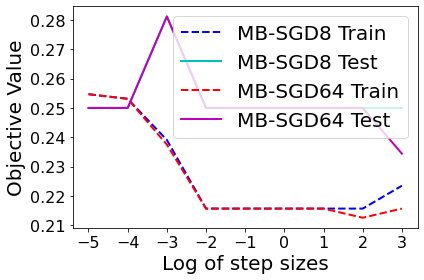

In [36]:



fig = plt.figure(figsize=(6, 4))

cutoff = 0

stepsizes_log = numpy.log10(stepsizes)

line0, = plt.plot(stepsizes_log, errors_train8, '--b', LineWidth = 2)
line1, = plt.plot(stepsizes_log, errors_test8, '-c', LineWidth = 2)
line2, = plt.plot(stepsizes_log, errors_train64, '--r', LineWidth = 2)
line3, = plt.plot(stepsizes_log, errors_test64, '-m', LineWidth = 2)
plt.xlabel('Log of step sizes', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['MB-SGD8 Train', 'MB-SGD8 Test', 'MB-SGD64 Train', 'MB-SGD64 Test'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('step_sizes.pdf', format='pdf', dpi=1200)

According to the graph, the learning rate where the train and test objective values are equal is around 0.0001. It is at this point that the model is not underfit nor overfit.

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  if sys.path[0] == '':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: MatplotlibDepre

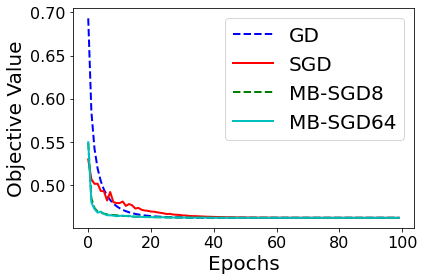

/usr/lib/python3/dist-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/lib/python3/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/lib/python3/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/lib/python3/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/lib/python3/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/lib/python3/dist-packages/ipykernel_laun

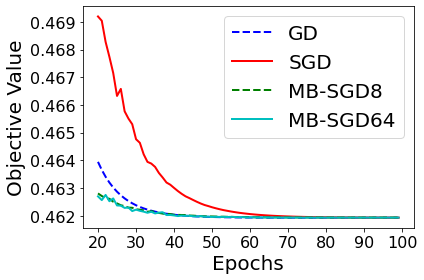

In [39]:
epochs_mbsgd8 = range(len(objvals_mbsgd8[0]))
epochs_mbsgd64 = range(len(objvals_mbsgd64[0]))


fig = plt.figure(figsize=(6, 4))

cutoff = 0

line0, = plt.plot(epochs_gd[cutoff:], objvals_gd[cutoff:], '--b', LineWidth=2)
line1, = plt.plot(epochs_sgd[cutoff:], objvals_sgd[cutoff:], '-r', LineWidth=2)
line2, = plt.plot(epochs_mbsgd8[cutoff:], objvals_mbsgd8[3][cutoff:], '--g', LineWidth = 2)
line3, = plt.plot(epochs_mbsgd64[cutoff:], objvals_mbsgd64[3][cutoff:], '-c', LineWidth = 2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MB-SGD8', 'MB-SGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_all.pdf', format='pdf', dpi=1200)

cutoff = 20

line0, = plt.plot(epochs_gd[cutoff:], objvals_gd[cutoff:], '--b', LineWidth=2)
line1, = plt.plot(epochs_sgd[cutoff:], objvals_sgd[cutoff:], '-r', LineWidth=2)
line2, = plt.plot(epochs_mbsgd8[cutoff:], objvals_mbsgd8[3][cutoff:], '--g', LineWidth = 2)
line3, = plt.plot(epochs_mbsgd64[cutoff:], objvals_mbsgd64[3][cutoff:], '-c', LineWidth = 2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1, line2, line3], ['GD', 'SGD', 'MB-SGD8', 'MB-SGD64'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_all.pdf', format='pdf', dpi=1200)